# London Airbnb Data Preparation

This notebook handles the loading, exploration, cleaning, and preparation of the Airbnb Listing Data.

## 1. Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import missingno as msno
import folium
from folium import Choropleth, GeoJson, GeoJsonTooltip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

## 2. Load Airbnb Data

In [2]:
# Read in the CSV file containing London Airbnb listings
london_airbnb = pd.read_csv('../../data/london/london_listings.csv')

# Read in the Geolytix town boundaries
london_glx = gpd.read_file('../../data/london/glondon_seamless.gpkg')

In [3]:
# Print the column names of the London Airbnb data
london_airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
# Keep only relevant columns
london_airbnb = london_airbnb[["id", "listing_url", "name", "neighbourhood", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "accommodates", "availability_eoy", "estimated_occupancy_l365d", "price", "estimated_revenue_l365d", "longitude", "latitude"]]

In [5]:
# Convert to GeoDataFrame
london_airbnb = gpd.GeoDataFrame(
    london_airbnb,
    geometry = gpd.points_from_xy(london_airbnb['longitude'], london_airbnb['latitude']),
    crs = 'EPSG:4326'
)

## 3. Exploration and Cleaning

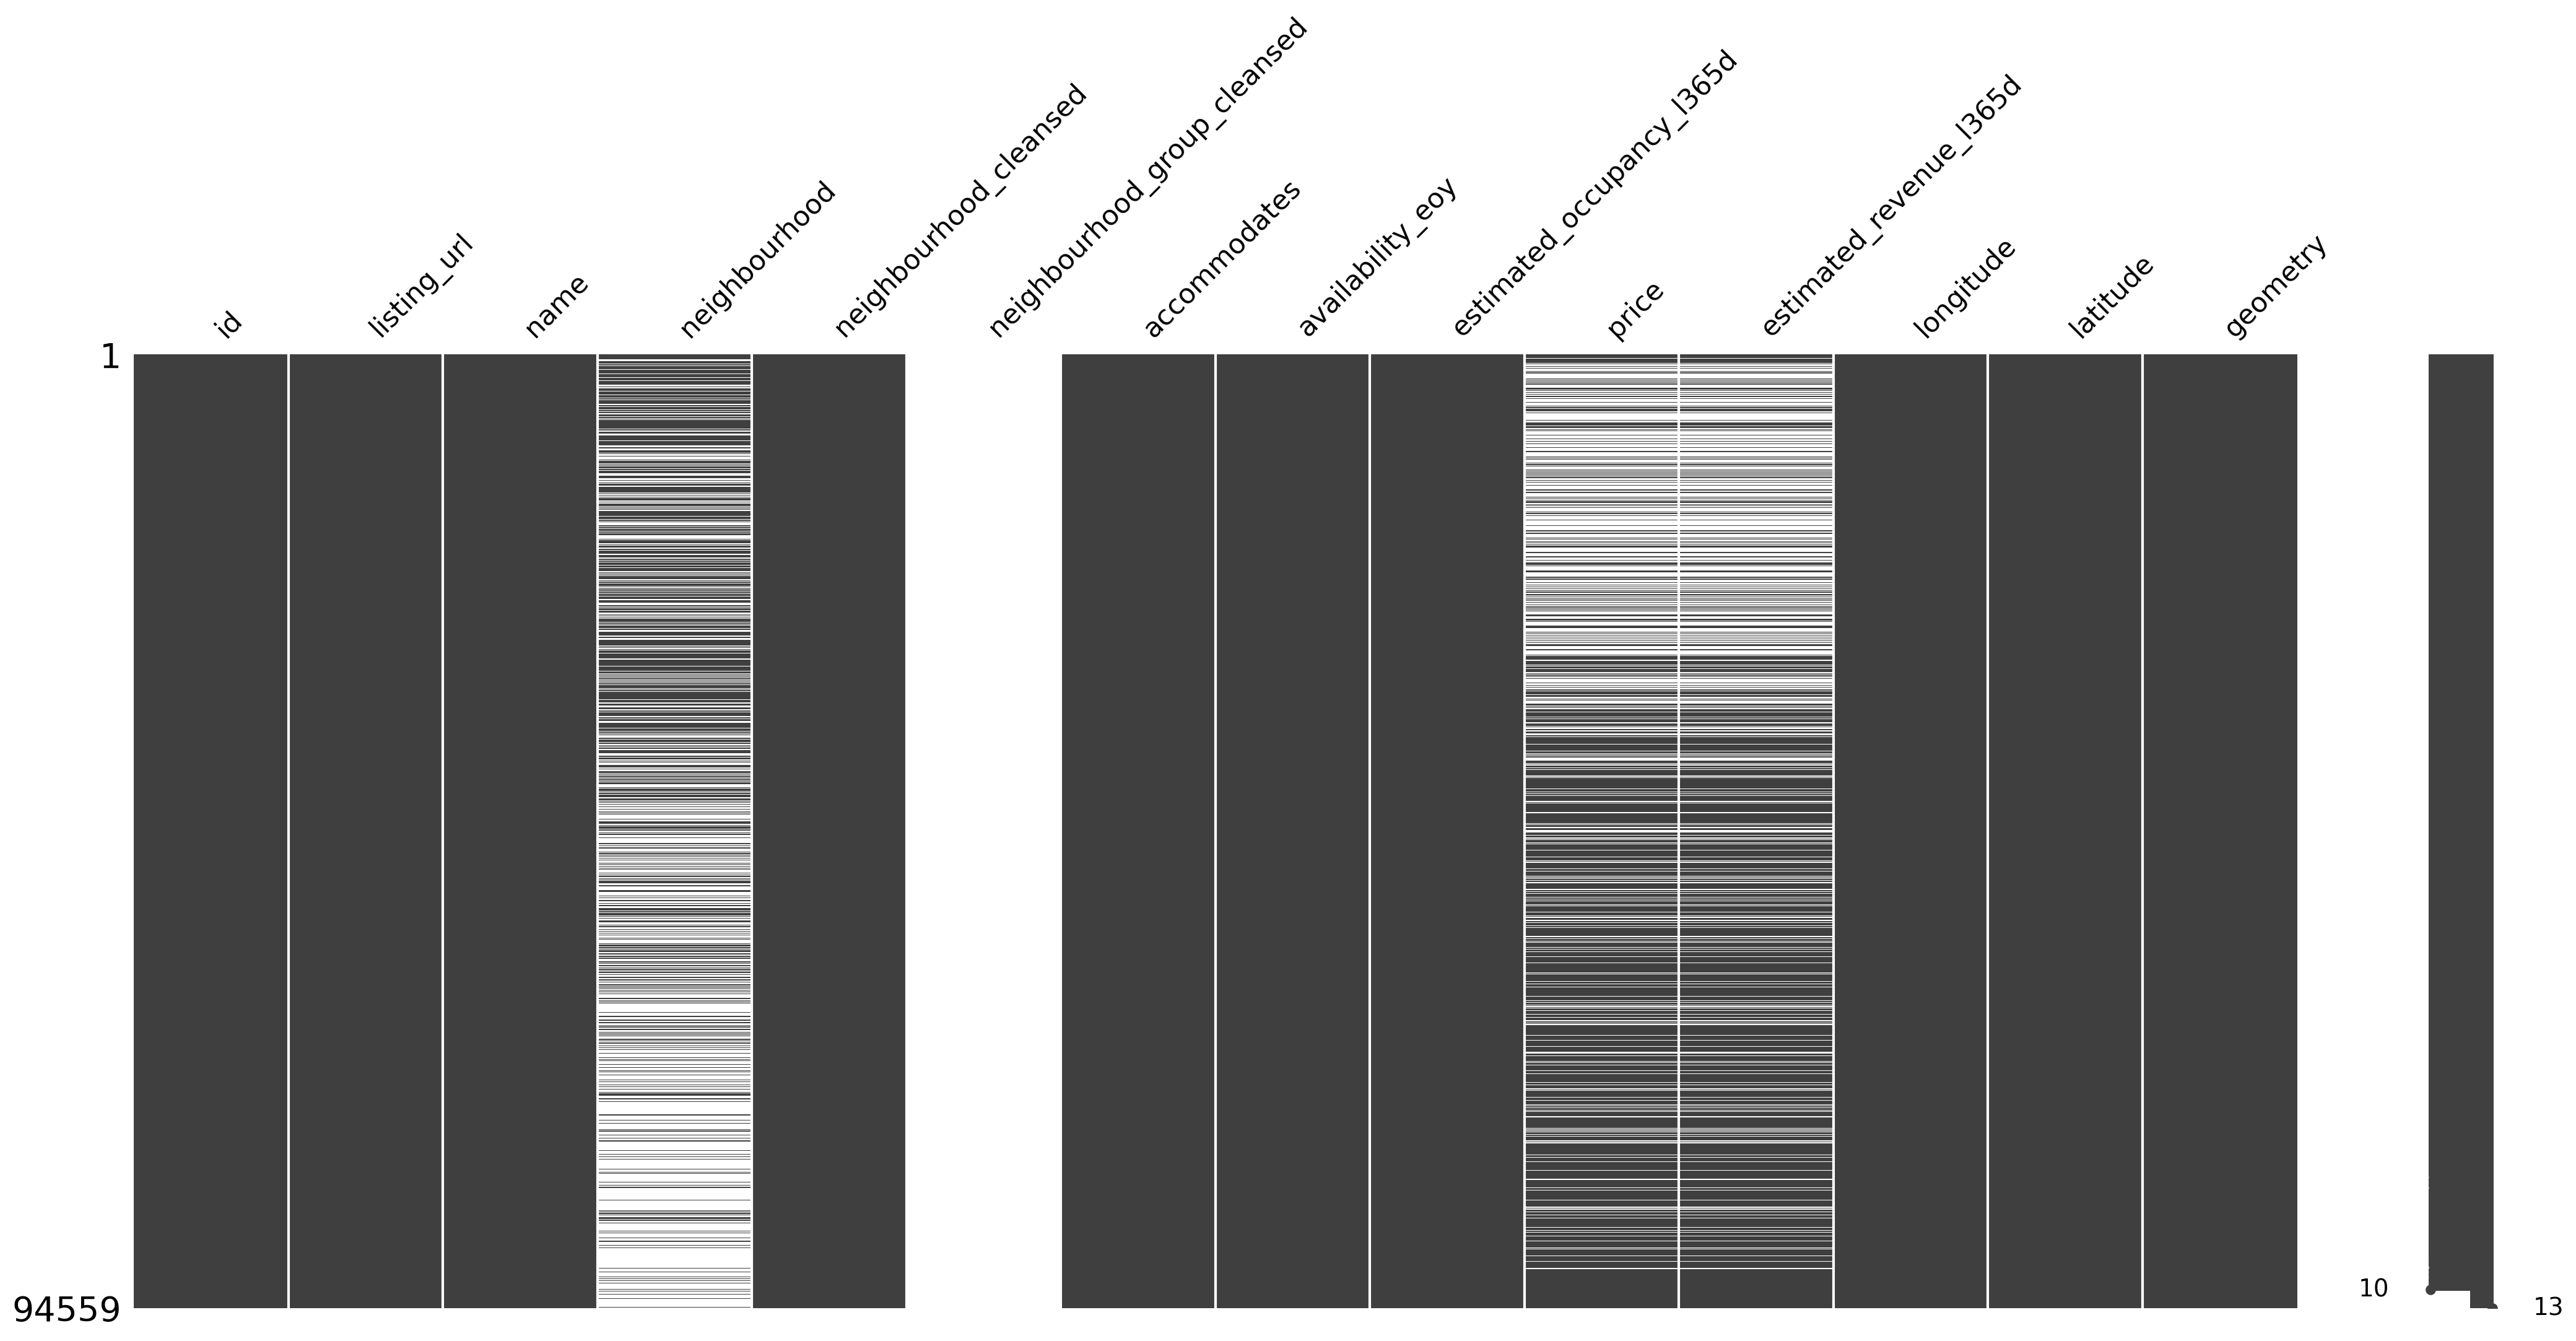

In [6]:
# Check for missing values
msno.matrix(london_airbnb);

A lot of listings do not have price available which is not useful for the analysis, therefore, these are removed.

In [7]:
# Remove properties where 'price' is NA
london_airbnb = london_airbnb.dropna(subset=['price'])

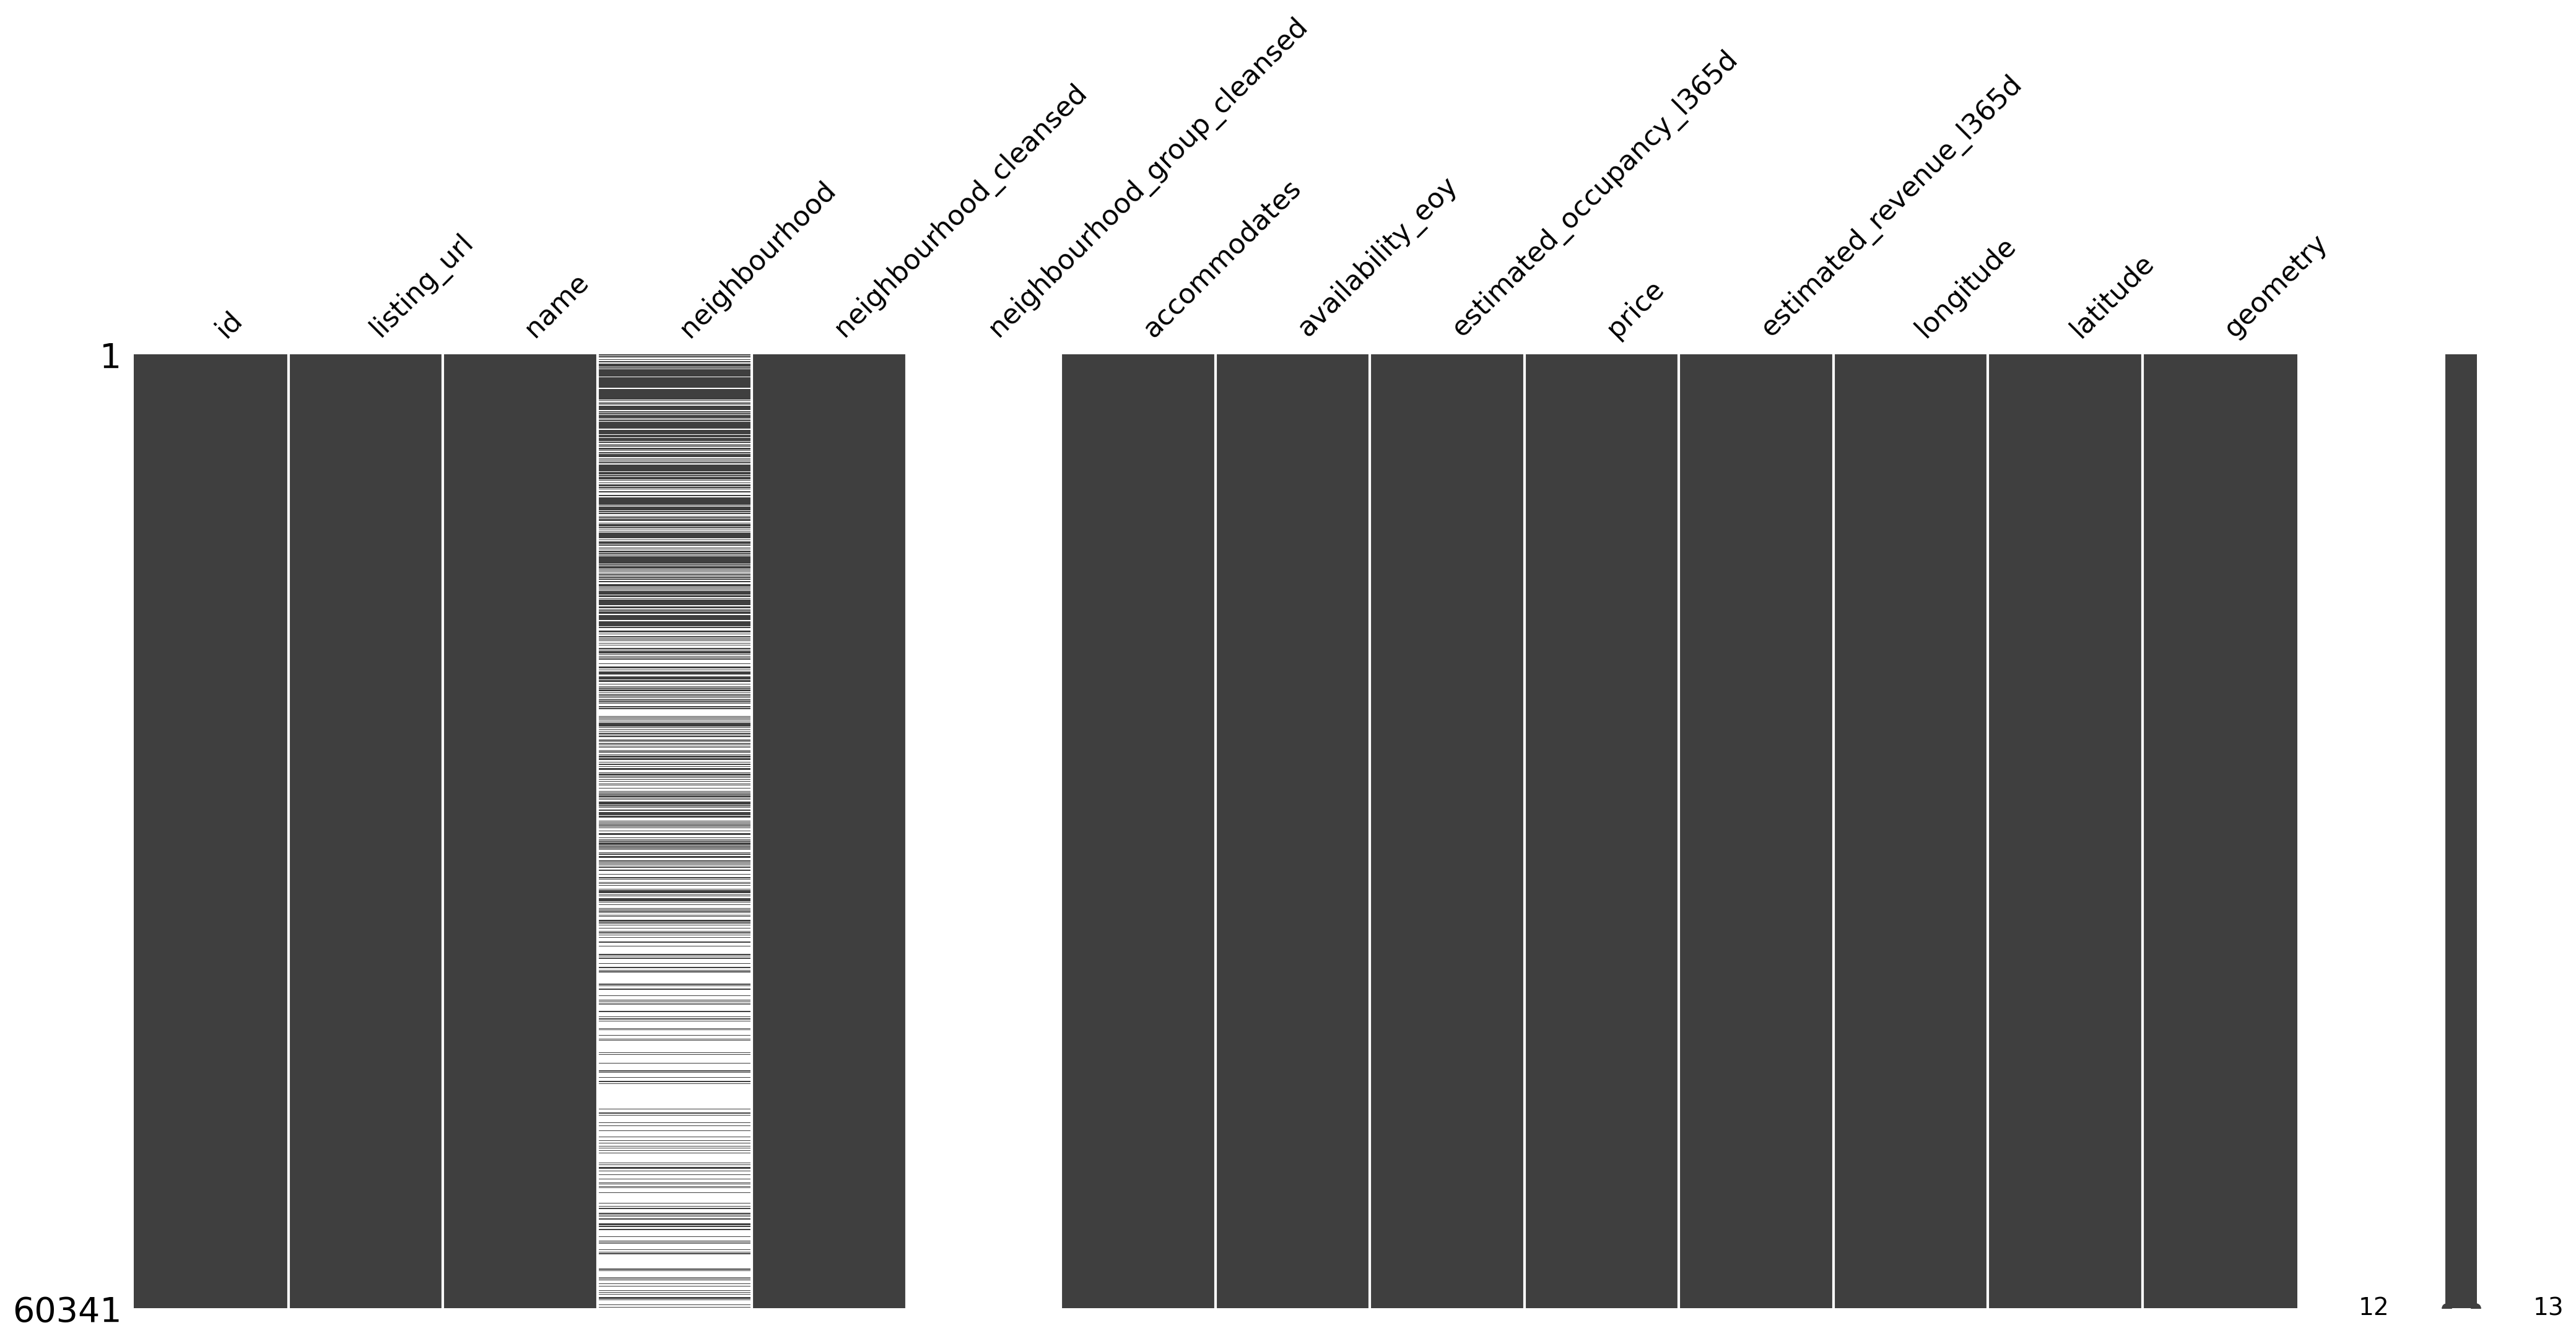

In [8]:
msno.matrix(london_airbnb);

A total of 34,218 properties (64%) have been dropped.

In [9]:
# Rename the id column in london_glx to glx_id
london_glx = london_glx.rename(columns={'id': 'glx_id'})

# Spatial join to attach glx_id to each Airbnb within the boundaries
london_airbnb_clipped = gpd.sjoin(
    london_airbnb, london_glx[['glx_id', 'geometry']],
    how = 'inner', predicate = 'within'
).copy()

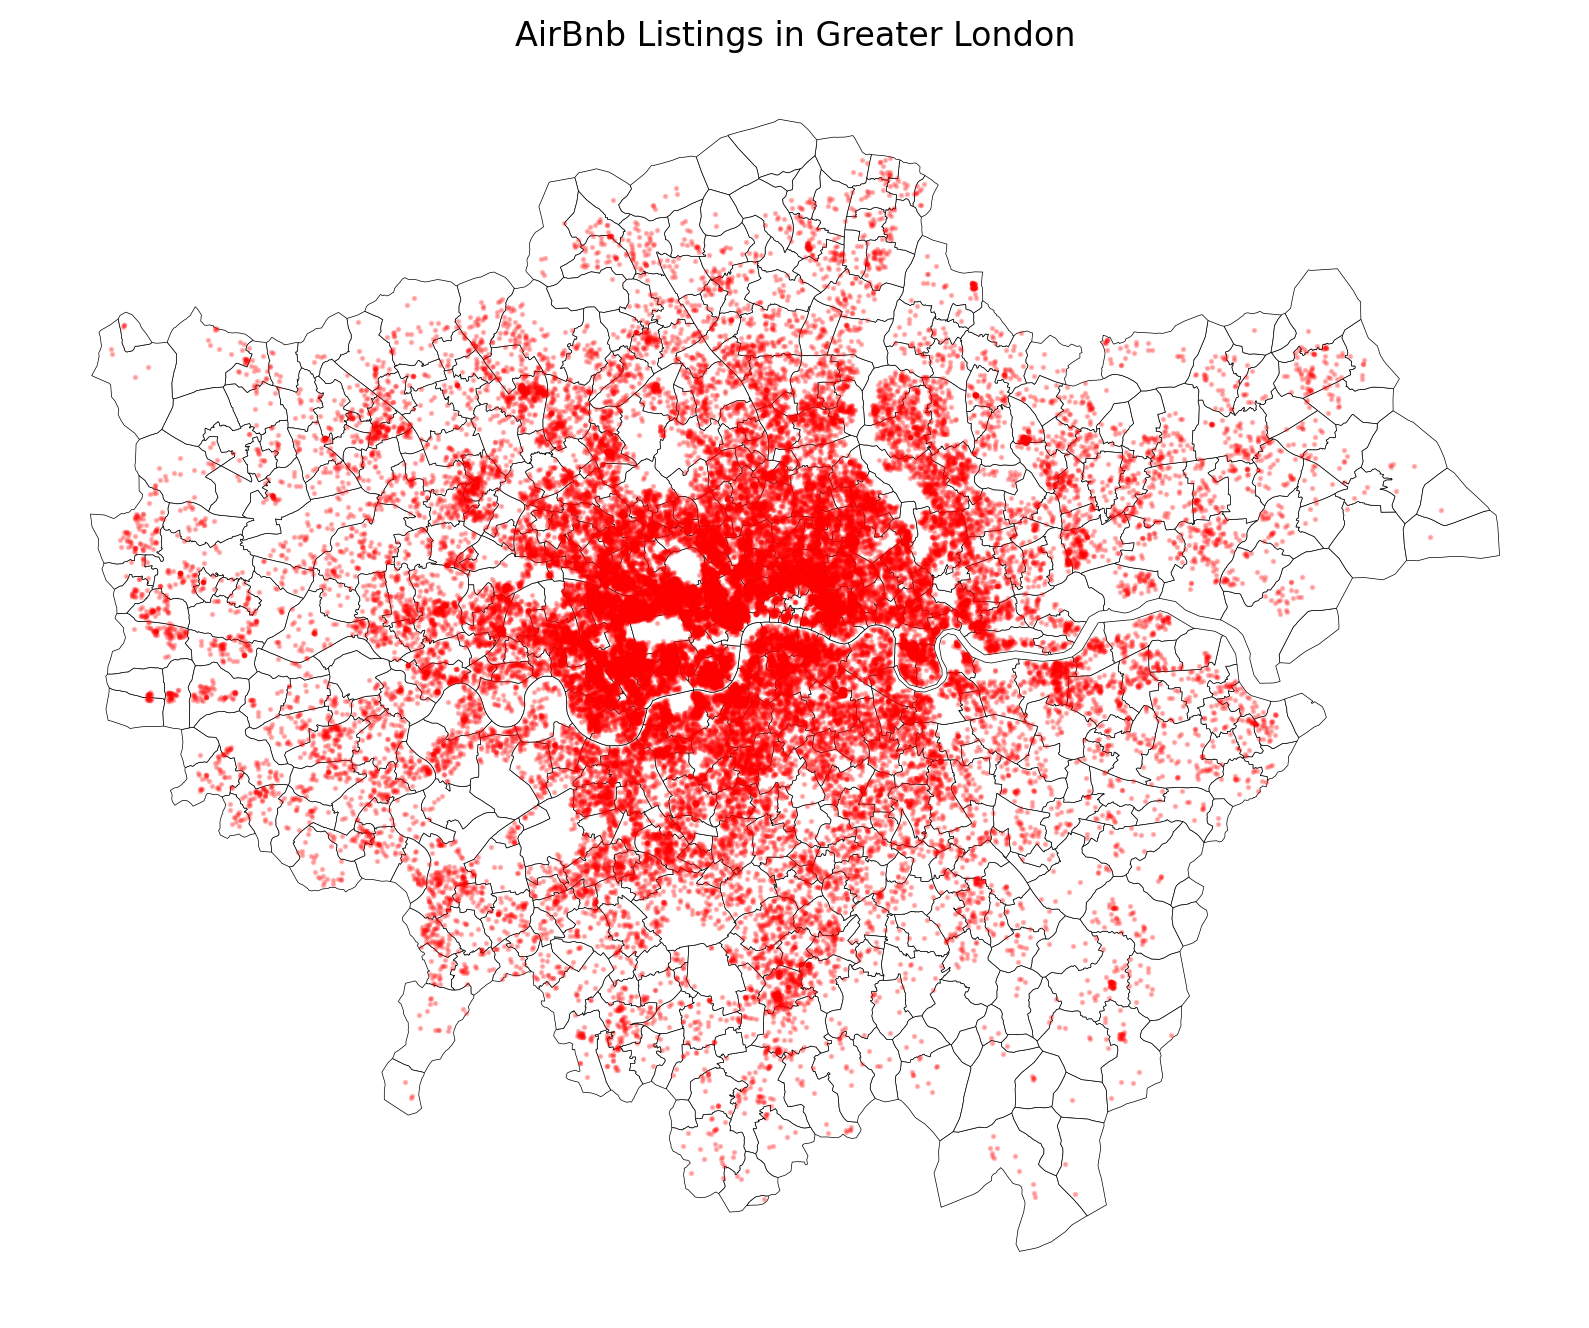

In [10]:
# Plot airbnbs
ax = london_glx.plot(figsize=(10, 10), color='white', edgecolor='black', linewidth=0.25)
# Plot the points
london_airbnb_clipped.plot(ax=ax, color = 'red', markersize=1, alpha=0.25)

ax.set_title("AirBnb Listings in Greater London")
ax.set_axis_off()

Airbnbs skewing the data (ids):
- 1367476686807313715 $11,952
    - This is a double ensuite room and clicking throguh the dates its ~£205 per night in the next few weeks or ~ £117 pn in December 2025, therefore, price from InsideAirbnb.com is way off.
    - Link to property: https://www.airbnb.co.uk/rooms/1367476686807313715?_set_bev_on_new_domain=1750246745_EANTU3NjU2MTRiMT&source_impression_id=p3_1750248682_P3aFH9BlHcw9ySkW
- 1270950739518691334 $9,999
    - This is an entire house in Harold Wood, that sleeps 8, 4 bedrooms. The house is not available / not booked up until May 2027, so cannot check this. Entire houses in central London go for ~£400 a night for same beds etc... so must be incorrect.
    - Link to property: https://www.airbnb.co.uk/rooms/1270950739518691334?_set_bev_on_new_domain=1750246745_EANTU3NjU2MTRiMT&source_impression_id=p3_1750247010_P3QWDLK0GaKvUxMM

In [11]:
# Remove listings with id 1270950739518691334
london_airbnb_clipped = london_airbnb_clipped[london_airbnb_clipped['id'] != 1270950739518691334]
london_airbnb_clipped = london_airbnb_clipped[london_airbnb_clipped['id'] != 1367476686807313715]

## 4. Feature Engineering

### Guest Volume

In [12]:
# Calculate the actual guest volme - i.e. an estimate of how many people actually stayed there in the past year
london_airbnb_clipped['estimated_guest_volume'] = (
    london_airbnb_clipped['accommodates'] *
    london_airbnb_clipped['estimated_occupancy_l365d']
)

### Variables per Town

In [13]:
# Get the number of properties in each town
london_airbnb_counts = (
    london_airbnb_clipped
    .groupby(['glx_id'])
    .size()
    .reset_index(name='property_count')
)

# Rename id column in london_glx to glx_id
london_glx = london_glx.rename(columns = {'id': 'glx_id'})

# Merge with geoms
london_glx_with_counts = london_glx.merge(
    london_airbnb_counts,
    on = "glx_id",
    how = "left"
)

# Fill NaN property counts with 0 (for LSOAs that had no listings)
london_glx_with_counts['property_count'] = london_glx_with_counts['property_count'].fillna(0).astype(int)

#### Total count of Listings

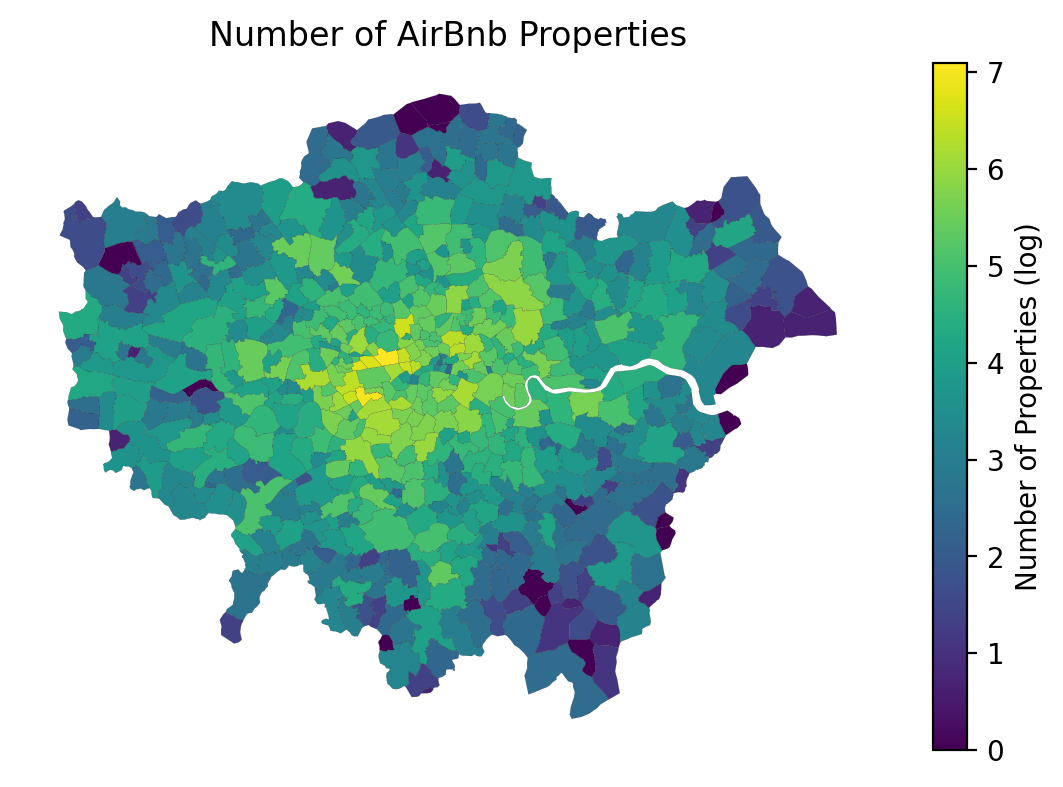

In [24]:
# Create log column
london_glx_with_counts['property_count_log'] = np.log1p(london_glx_with_counts['property_count'])

# Plot the counts
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

london_glx_with_counts.plot(
    column = 'property_count_log',
    cmap = 'viridis',
    legend = True,
    ax = ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of Properties (log)", 'orientation': "vertical"}
)
ax.set_title("Number of AirBnb Properties", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

#### Density of Listings

In [23]:
# Reproject to a projected CRS
london_glx_with_density = london_glx_with_counts.to_crs(epsg=27700)

# Now calculate density correctly (properties per square meter)
london_glx_with_density['density_m2'] = london_glx_with_density['property_count'] / london_glx_with_density.geometry.area

# Per square kilometer
london_glx_with_density['density_km2'] = london_glx_with_density['density_m2'] / 1e6 

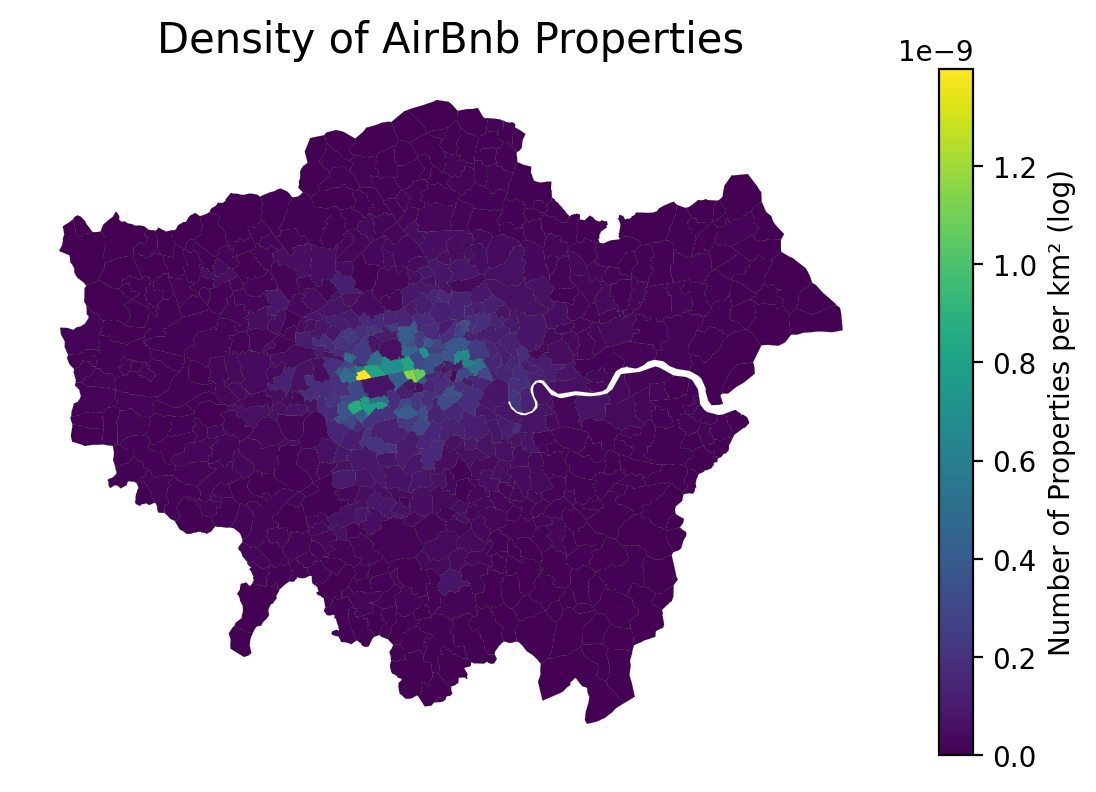

In [22]:
# Log the density
london_glx_with_density['log_density_km2'] = np.log1p(london_glx_with_density['density_km2'])

london_glx_with_density['log_density_m2'] = np.log1p(london_glx_with_density['density_m2'])

# Plot the density
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

london_glx_with_density.plot(
    column = 'density_km2',
    cmap = 'viridis',
    legend = True,
    ax = ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of Properties per km² (log)", 'orientation': "vertical"}
)
ax.set_title("Density of AirBnb Properties", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()